# Converting a Shapefile of Electoral Districs to raster images

In [2]:
# loading packages
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import cv2
import os 
import contextily as cx

from pathlib import Path
from shapely.ops import cascaded_union
from shapely import oriented_envelope, affinity, unary_union, Polygon, MultiPolygon, Point
from rasterio.features import rasterize, Affine

In [10]:
input_gdf = gpd.read_file("ire_ED/Electoral_Divisions_-_National_Statutory_Boundaries_-_2019.shp")

In [15]:
# define our functions
def multi_to_poly(multipoly):
    polygons = [poly for poly in multipoly.geoms]
    return gpd.GeoDataFrame(pd.DataFrame(polygons, columns=['geometry']), geometry='geometry', crs=4326)

def gdf_multi_to_poly(gdf):
    gdf_out = gpd.GeoDataFrame(pd.DataFrame([], columns=['geometry']),geometry='geometry', crs=gdf.crs)
    for i in range(gdf.shape[0]):
        if isinstance(gdf['geometry'][i], shapely.geometry.multipolygon.MultiPolygon):
            gdf_dissolve = multi_to_poly(gdf['geometry'][i])
            gdf_dissolve['admin'] = gdf['ADMIN'][i]
            gdf_out = pd.concat([gdf_out, gdf_dissolve],ignore_index=True)
        else:
            gdf_dissolve = gdf.iloc[[i]]
            gdf_dissolve['admin'] = gdf['ADMIN'][i]
            gdf_out = pd.concat([gdf_out, gdf_dissolve],ignore_index=True)
    return gdf_out

def gdf_poly_scaling(gdf, window=128, crs=3857):
    scaled = gdf.copy().to_crs(3857)
    # establish the previous area value, height, width, and ratio of the polygons
    scaled['area_old'] = scaled.geometry.area
    scaled['ratio'] = scaled.geometry.apply(lambda row: (row.bounds[2]-row.bounds[0])/(row.bounds[3]-row.bounds[1]))
    scaled['width'] = scaled.geometry.apply(lambda row: row.bounds[2]-row.bounds[0])
    scaled['height'] = scaled.geometry.apply(lambda row: row.bounds[3]-row.bounds[1])
    # affine translate polygons to (0,0) as their centroid
    scaled.geometry = scaled.apply(lambda row: affinity.translate(row.geometry, xoff=-row.geometry.centroid.x, yoff=-row.geometry.centroid.y), axis=1)
    # Scale to fit the given window size
    scaled.geometry = scaled.apply(lambda row: affinity.scale(row.geometry, xfact=window/row.width if row.ratio > 1 else window/row.height , yfact=window/row.height if row.ratio < 1 else window/row.width, origin=(row.geometry.centroid.x, row.geometry.centroid.y)), axis=1)
    # put it in the positive axes
    scaled.geometry = scaled.apply(lambda row: affinity.translate(row.geometry, xoff=-row.geometry.bounds[0] , yoff=-row.geometry.bounds[1]), axis=1)
    scaled.geometry = scaled.apply(lambda row: affinity.translate(row.geometry, xoff=window/2 - row.geometry.centroid.x if row.ratio < 1 else 0, yoff=window/2 - row.geometry.centroid.y if row.ratio > 1 else 0), axis=1)
    # store new area as variable
    scaled['area_new'] = scaled.geometry.area
    
    return scaled


In [16]:
window_size = 128

gdf_scaled = gdf_poly_scaling(input_gdf, window_size)

In [24]:
print(gdf_scaled.iloc[[2095]])

       ED_ID           ENGLISH                 GAEILGE             CONTAE  \
2095  267079  DUNDRUM-KILMACUD  Dún Droma-Cill Mochuda  Baile Átha Cliath   

      COUNTY  PROVINCE                                  GUID  CENTROID_X  \
2095  DUBLIN  Leinster  2ae19629-1d5b-13a3-e055-000000000001   717726.68   

      CENTROID_Y       AREA  ESRI_OID     Shape__Are   Shape__Len  \
2095    727889.5  917743.49      2096  917743.493073  4541.834482   

                                               geometry      area_old  \
2095  POLYGON ((36.143 47.373, 35.156 48.573, 34.448...  2.563368e+06   

         ratio        width       height     area_new  
2095  1.424713  2589.281947  1817.406335  6264.295089  


In [18]:
cdir = os.getcwd() 
os.makedirs(Path(os.path.dirname(cdir),"ed_rasters"),  exist_ok=True)
rasters = [rasterize(gpd.GeoSeries(poly), out_shape=(window_size, window_size)) for poly in gdf_scaled.geometry]

for i, raster in enumerate(rasters):
    cv2.imwrite(str(Path(os.path.dirname(cdir),f"ed_rasters/{i}.png")), cv2.flip(raster*255, 0))

<Axes: >

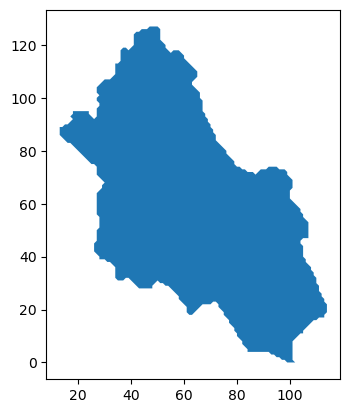

In [28]:
raster_img = cv2.imread(str(Path(os.path.dirname(cdir),f"ed_rasters/1.png")), cv2.IMREAD_GRAYSCALE)

contours, _ = cv2.findContours(cv2.flip(raster_img,0), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
polygons = [np.array(polygon).squeeze() for polygon in contours]

raster_to_poly = MultiPolygon([Polygon(poly) for poly in polygons])

gpd.GeoSeries(raster_to_poly).plot()

bl (-1761021.7953520997, 5858780.3373512495)
tr (-1760528.9438454753, 5859077.178579861)
random centre: 0    POINT (-1760835.894 5859050.097)
dtype: geometry


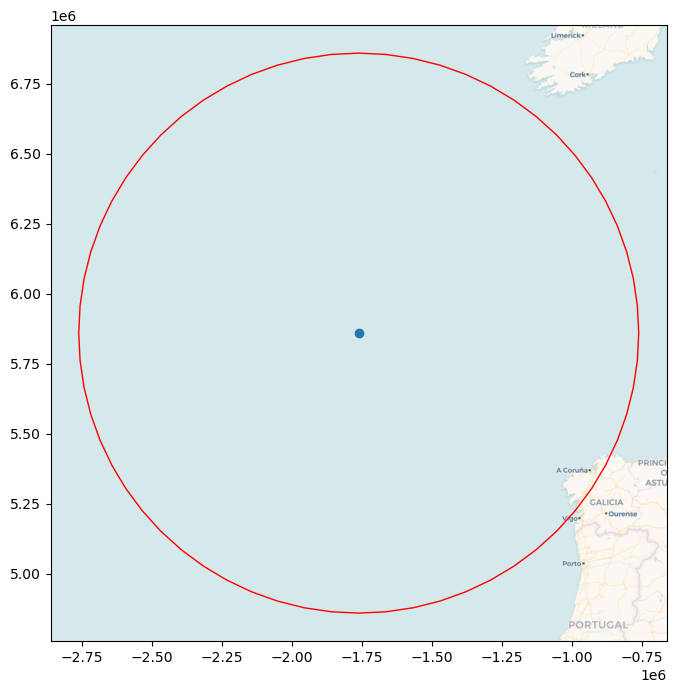

In [57]:
import random
from pyproj import CRS, Transformer

in_crs = CRS.from_epsg(2157)
out_crs = CRS.from_epsg(3857)
x_min, y_min, x_max, y_max = out_crs.area_of_use.bounds

proj = Transformer.from_crs(2157, 3857, always_xy=True)
bl = proj.transform(x_min, y_min)
tr = proj.transform(x_max, y_max)

print("bl", bl)
print("tr", tr)

random_centre = gpd.GeoSeries(Point([random.uniform(bl[0], tr[0]), random.uniform(bl[1], tr[1])]), crs=3857)#.to_crs(4326)
#random_centre = gpd.GeoSeries(Point([0, 0]))

fig, ax = plt.subplots(1,1,figsize=(10,8))

#gpd.GeoSeries(random_3857).plot(ax=ax)
#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

print("random centre:", random_centre)

#centroid_buffer.plot(ax=ax, edgecolor='red', facecolor='none')
random_centre.plot(ax=ax)
random_centre.buffer(1000000,join_style=2).plot(ax=ax, edgecolor='red', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

